In [ ]:
import sys, os

if 'COLAB_GPU' in os.environ:
    print("Running on Google Colab, setting up environment")
    colab = True
    !pip install scikit-video

    !mkdir -p ./src/data  
    !mkdir -p ./src/modules  
    !mkdir -p ./data
    !mkdir -p ./models

    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/build_features.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/compute_surprise.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/load_pose_data.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/merge_data_sets.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/preprocess_pose_data.py


    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/circstats.py
    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/skeleton.py
    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/util_data.py
    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/util_vis.py

    sys.path.insert(0,'./src/data')
    sys.path.insert(0,'./src/modules')

    data_path = './data'
    model_path = './models'
    home_path = './'

else: 
    colab = False
    sys.path.insert(0,'../src/data')
    sys.path.insert(0,'../src/modules')

    data_path = '../data'
    model_path = '../models'
    home_path = '../'


In [2]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec


import load_pose_data
import skvideo.io
import itertools
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.linalg import svd
import preprocess_pose_data, build_features, merge_data_sets, compute_surprise
import  util_vis
from util_vis import plot_skel, gen_one_frame, get_one_frame, normm

from skeleton import Skeleton


In [ ]:
def setup_env():
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    #if data directory is empty, rerun setup 
    if not os.path.exists(data_path) or len(os.listdir(data_path)) == 0:

        if colab:
            !wget https://figshare.com/ndownloader/files/15593963?private_link=10034c230ad9b2b2a6a4 -O ./pose_data.zip
            !unzip -o ./pose_data.zip -d ./


            !mv --force ./infant_movement_assessment_repo_files/data/* ./data
            !mv --force ./infant_movement_assessment_repo_files/models/* ./models

            !rm ./pose_data.zip
            !rm -r ./infant_movement_assessment_repo_files

        else:
            !wget https://figshare.com/ndownloader/files/15593963?private_link=10034c230ad9b2b2a6a4 -O ../pose_data.zip
            !unzip -o ../pose_data.zip -d ../


            !mv --force ../infant_movement_assessment_repo_files/data/* ../data
            !mv --force ../infant_movement_assessment_repo_files/models/* ../models

            !rm ../pose_data.zip
            !rm -r ../infant_movement_assessment_repo_files
    else: 
        print('setup for this project has already been done. Skipping download and extraction of data.')

def compute_kinematics(datasets, data_path):
    for data_set in data_sets:
        print(f'Processing {data_set} data set')

        raw_pose_estimates_video_path = f'{data_path}/pose_estimates/{data_set}/py/pose_estimates.pkl'
        assert os.path.exists(raw_pose_estimates_video_path), 'Folder does not exist. \n Edit path to pose estimate data (raw_pose_estimates_video_path) in notebooks/infant_move/master.ipynb, Cell 2.'

        #load_pose_data.main(data_set, raw_pose_estimates_video_path)
        preprocess_pose_data.main(data_set, data_path)
        build_features.main(data_set, data_path)


In [4]:
data_sets = ['youtube', 'clinical']
age_threshold = 10

processed_data_path = f'{data_path}/processed/'

feature_path = f'{data_path}/interim'
meta_data_path = f'{data_path}/video_meta_data'
save_path = f'{data_path}/processed'

In [ ]:
setup_env()
compute_kinematics(data_sets, data_path)
merge_data_sets.main(feature_path, meta_data_path, save_path, age_threshold)
compute_surprise.main(processed_data_path)




In [5]:
kp = Skeleton()

surprise = pd.read_pickle(os.path.join(processed_data_path, 'bayes_surprise.pkl'))
features = pd.read_pickle(os.path.join(processed_data_path, 'final_feature_set.pkl'))


labels_list_part = [i.split('_')[0] for i in kp.feature_list]


feature_label_df = pd.DataFrame.from_dict({'feature':kp.feature_list, 
                                            'feature_label':kp.labels_list_feature,
                                            'feature_label_2':kp.labels_list_feature_2,
                                            'feature_label_3':kp.labels_list_feature_3,
                                            'part_label':labels_list_part, 
                                            'full_feature_label':kp.labels_list})


features = pd.merge(features, feature_label_df, on='feature', how='outer')
features_norm = features.groupby('feature').apply(normm).reset_index(drop=True)
feature_table = pd.pivot_table(features_norm, values='Value', index=['infant','risk'], columns=['feature','feature_label_3'])


## Figure 1

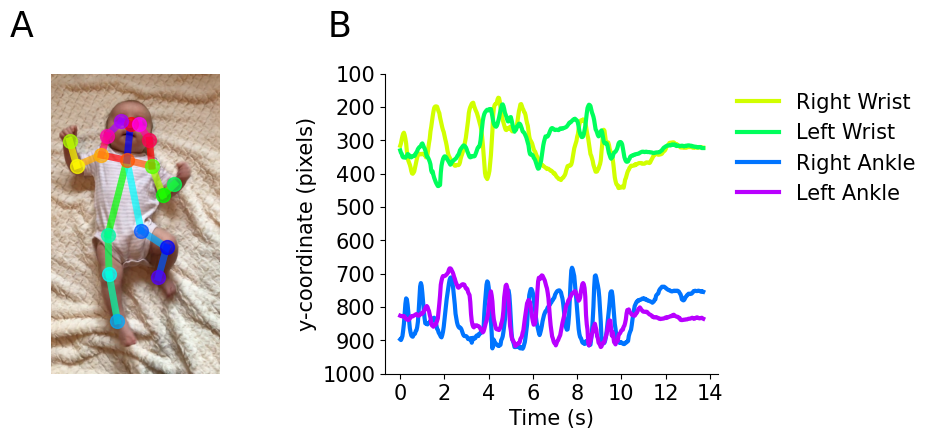

In [6]:
data_set = 'example_video'
path = f'{data_path}/example_video'
pose_path = f'{data_path}/pose_estimates/example_video/py/pose_estimates.pkl'
fontsize_panel = 25
load_pose_data.main(data_set, path, data_path)

df = pd.read_pickle(pose_path)
vid = 'video_exampl'
vidpath = os.path.join(path,vid+'.mov')
frame1 = 55
framen = 56
frame_interval = 1
xvar = 'x'
yvar = 'y'

fontsize=15
fig,axs=plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax = axs[0]
ax.text(-.1, 1.1, 'A', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
img = get_one_frame(vidpath,framen)
ax.imshow(img)

for i in np.arange(frame1,framen,frame_interval):
    plot_skel(df[df.frame==i], vid, i, ax, xvar,yvar, kp.limbSeq, kp.colors)
    
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = axs[1]
ax.text(-.1, 1.1, 'B', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
df = df[np.isin(df.bp, ['LAnkle', 'RAnkle', 'LWrist', 'RWrist'])]
df.loc[df.bp=='LAnkle','bp'] = 'Left Ankle'
df.loc[df.bp=='RAnkle','bp'] = 'Right Ankle'
df.loc[df.bp=='LWrist','bp'] = 'Left Wrist'
df.loc[df.bp=='RWrist','bp'] = 'Right Wrist'
df['Body part'] = df['bp']
df['time'] = df['frame']/30
sns.lineplot(x='time', y='y', hue='Body part', data=df, ax = ax, palette="hsv", linewidth=3)
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('y-coordinate (pixels)',fontsize=fontsize)
ax.invert_yaxis()
ax.set_yticks(np.arange(100,1100, step=100))
ax.set_yticklabels(np.arange(100,1100, step=100),fontsize=fontsize)
ax.set_xticks(np.arange(0,16, step=2))
ax.set_xticklabels(np.arange(0,16, step=2),fontsize=fontsize)
ax.legend(bbox_to_anchor=(1,1), frameon=False,fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
fig.subplots_adjust(left=.05, bottom=.2, right=.8, top=.8, wspace=.25, hspace=.2)

## Figure 2

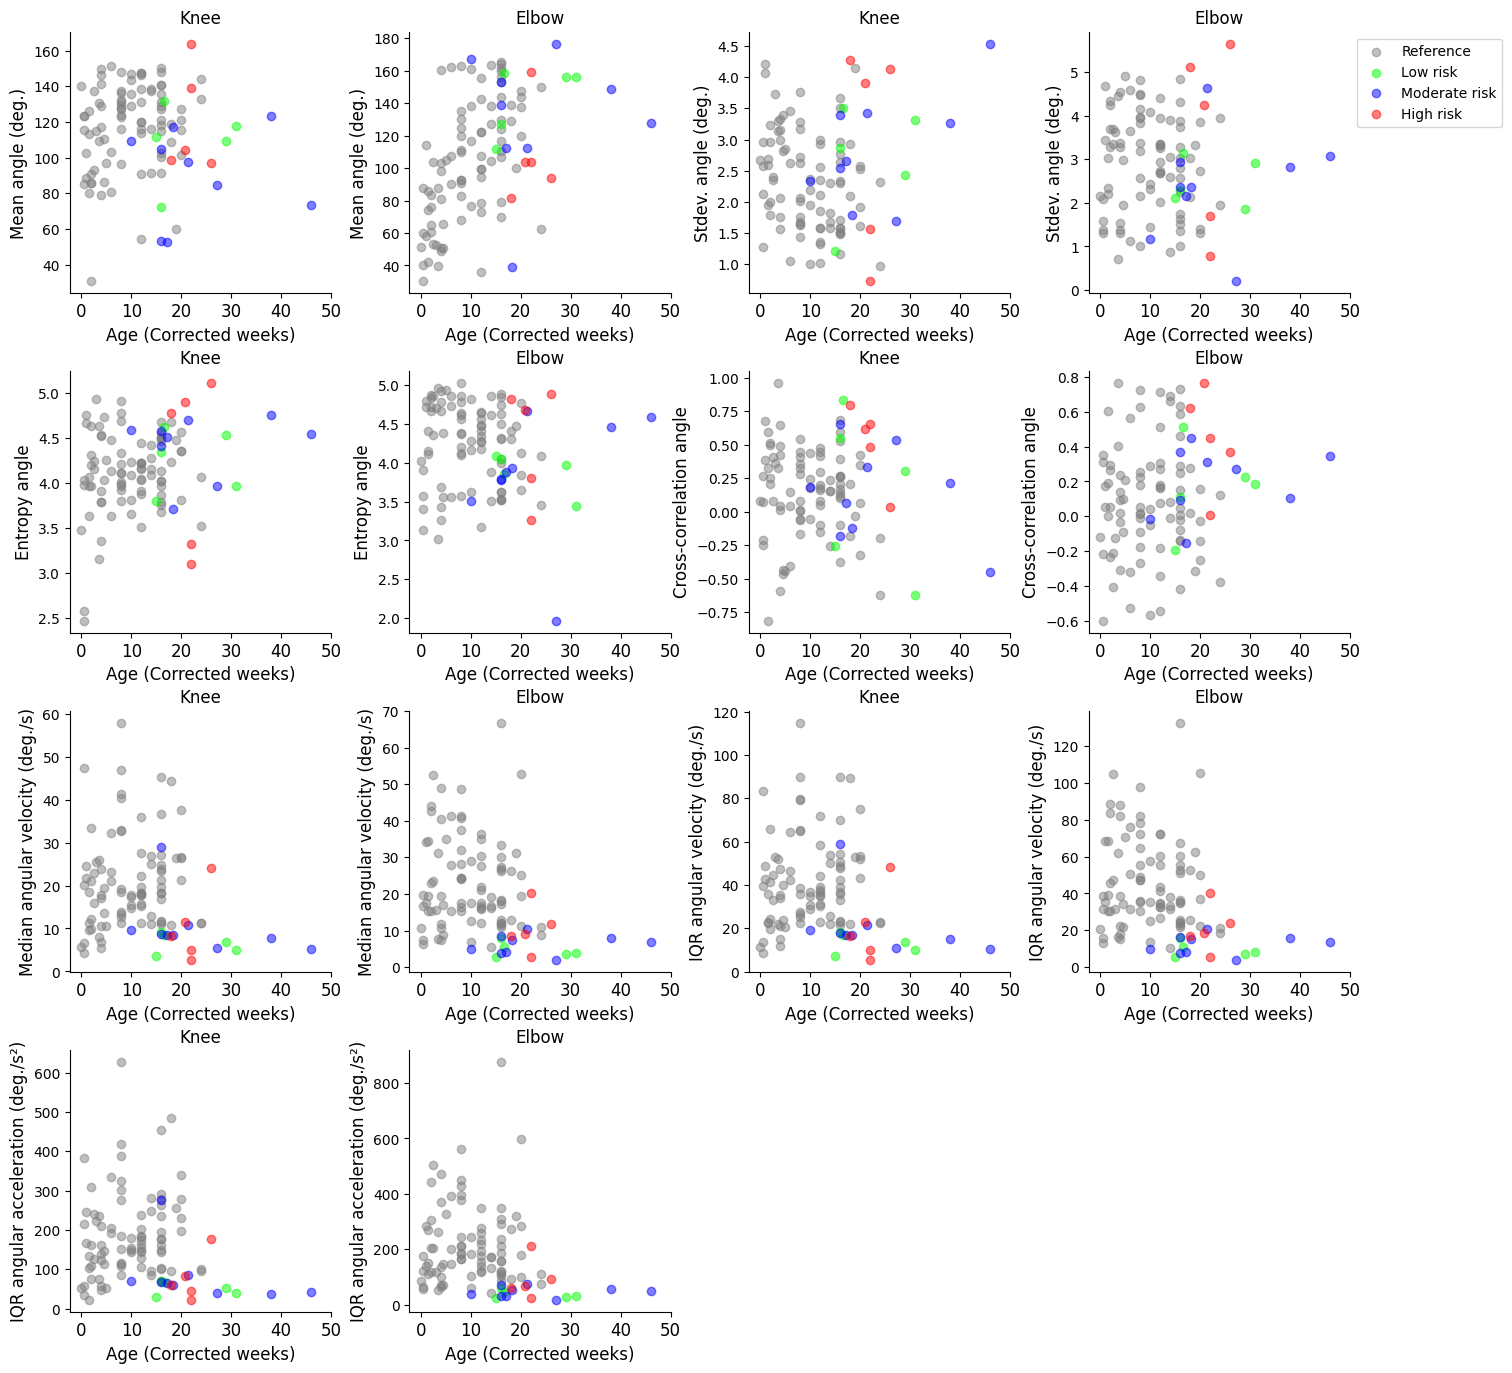

In [7]:
fontsize = 12
s = 4

nrow = 4
ncol = 4

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(ncol*s, nrow*s))
for i, icol in enumerate(kp.feature_list_angle):
    
    ax = axs.flat[i]
#     ax.text(xlabel, ylabel, labelz[i], transform=ax.transAxes,fontsize=fontsize_label, va='top', ha='right')
    sns.regplot(data=features[(features.risk==0)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5},label='Reference')
    sns.regplot(data=features[(features.risk==1)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5},label='Low risk')
    sns.regplot(data=features[(features.risk==2)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5},label='Moderate risk')
    sns.regplot(data=features[(features.risk==3)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5},label='High risk')
    if i==3:
        ax.legend(bbox_to_anchor=(1,1))    
    ax.set_ylabel(features[features.feature==icol].feature_label.unique()[0],fontsize=fontsize)
    ax.set_title(features[features.feature==icol].part.unique()[0],fontsize=fontsize)
    ax.set_xlabel('Age (Corrected weeks)',fontsize=fontsize)
    ax.set_xticks(np.arange(0,60,step=10))
    ax.set_xticklabels(np.arange(0,60,step=10), fontsize=fontsize)
fig.subplots_adjust(left=.1, bottom=.1, right=.9, top=.9, wspace=.3, hspace=.3) 
sns.despine()
axs.flat[-1].remove()
axs.flat[-2].remove()

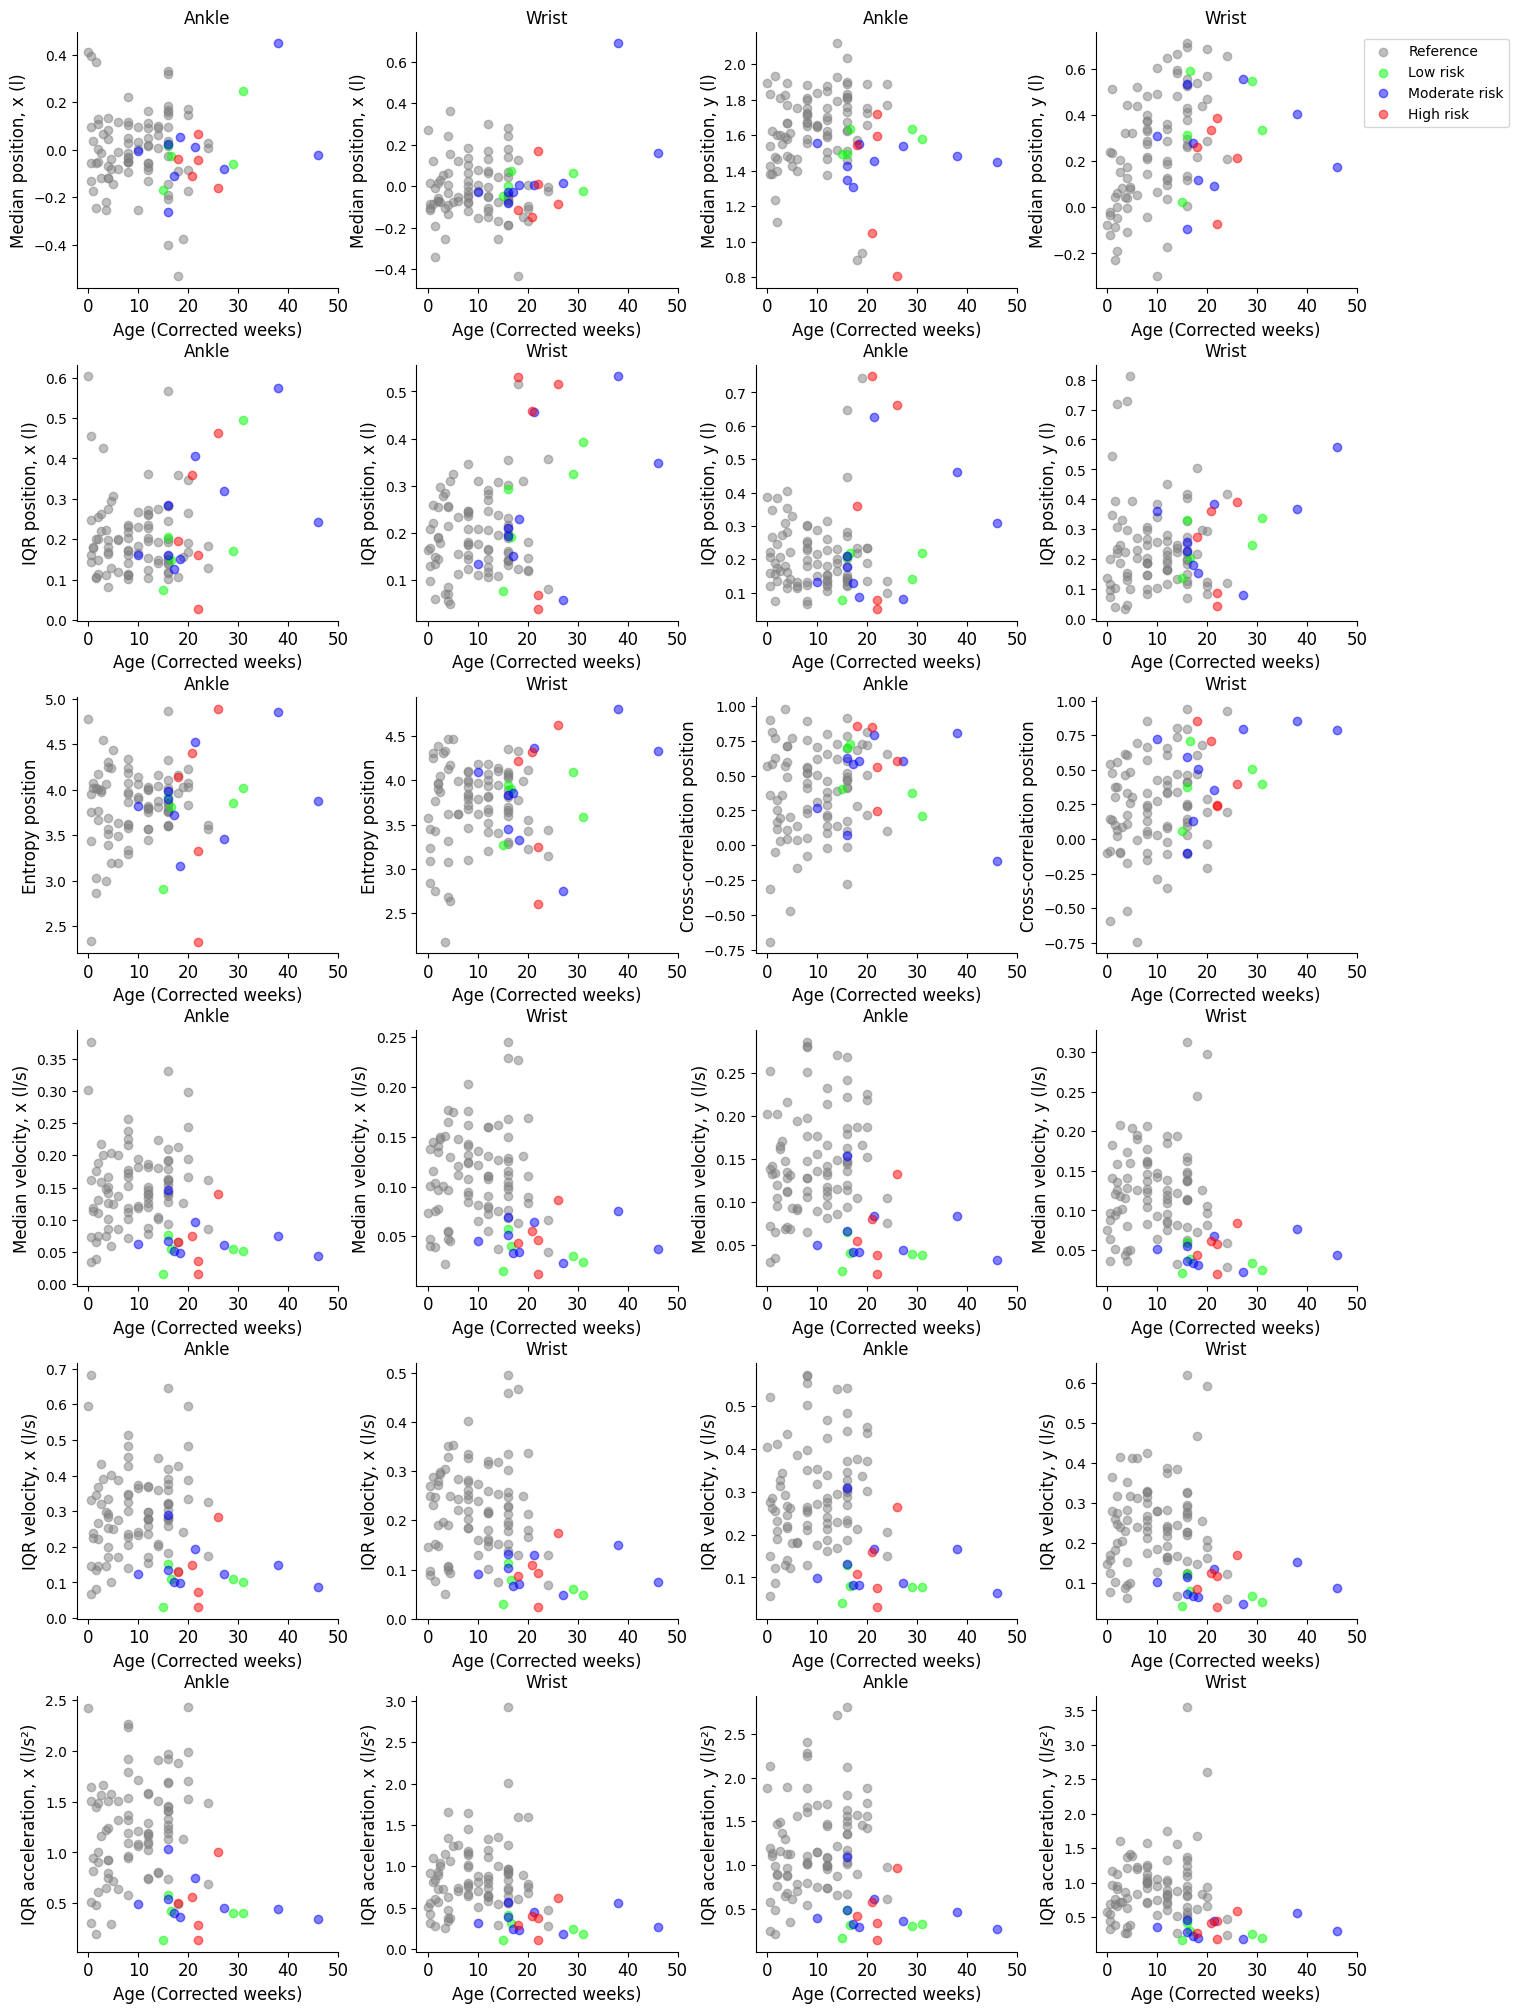

In [9]:
nrow = 6
ncol = 4
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(ncol*s, nrow*s))
for i, icol in enumerate(kp.feature_list_x):
    ax = axs.flat[i]
#     ax.text(xlabel, ylabel, labelz[i], transform=ax.transAxes,fontsize=fontsize_label, va='top', ha='right')
    sns.regplot(data=features[(features.risk==0)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5},label='Reference')
    sns.regplot(data=features[(features.risk==1)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5},label='Low risk')
    sns.regplot(data=features[(features.risk==2)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5},label='Moderate risk')
    sns.regplot(data=features[(features.risk==3)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5},label='High risk')
    if i==3:
        ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel(features[features.feature==icol].feature_label.unique()[0],fontsize=fontsize)
    ax.set_title(features[features.feature==icol].part.unique()[0],fontsize=fontsize)
    ax.set_xlabel('Age (Corrected weeks)',fontsize=fontsize)
    ax.set_xticks(np.arange(0,60,step=10))
    ax.set_xticklabels(np.arange(0,60,step=10), fontsize=fontsize)
fig.subplots_adjust(left=.1, bottom=.1, right=.9, top=.9, wspace=.3, hspace=.3) 
sns.despine()

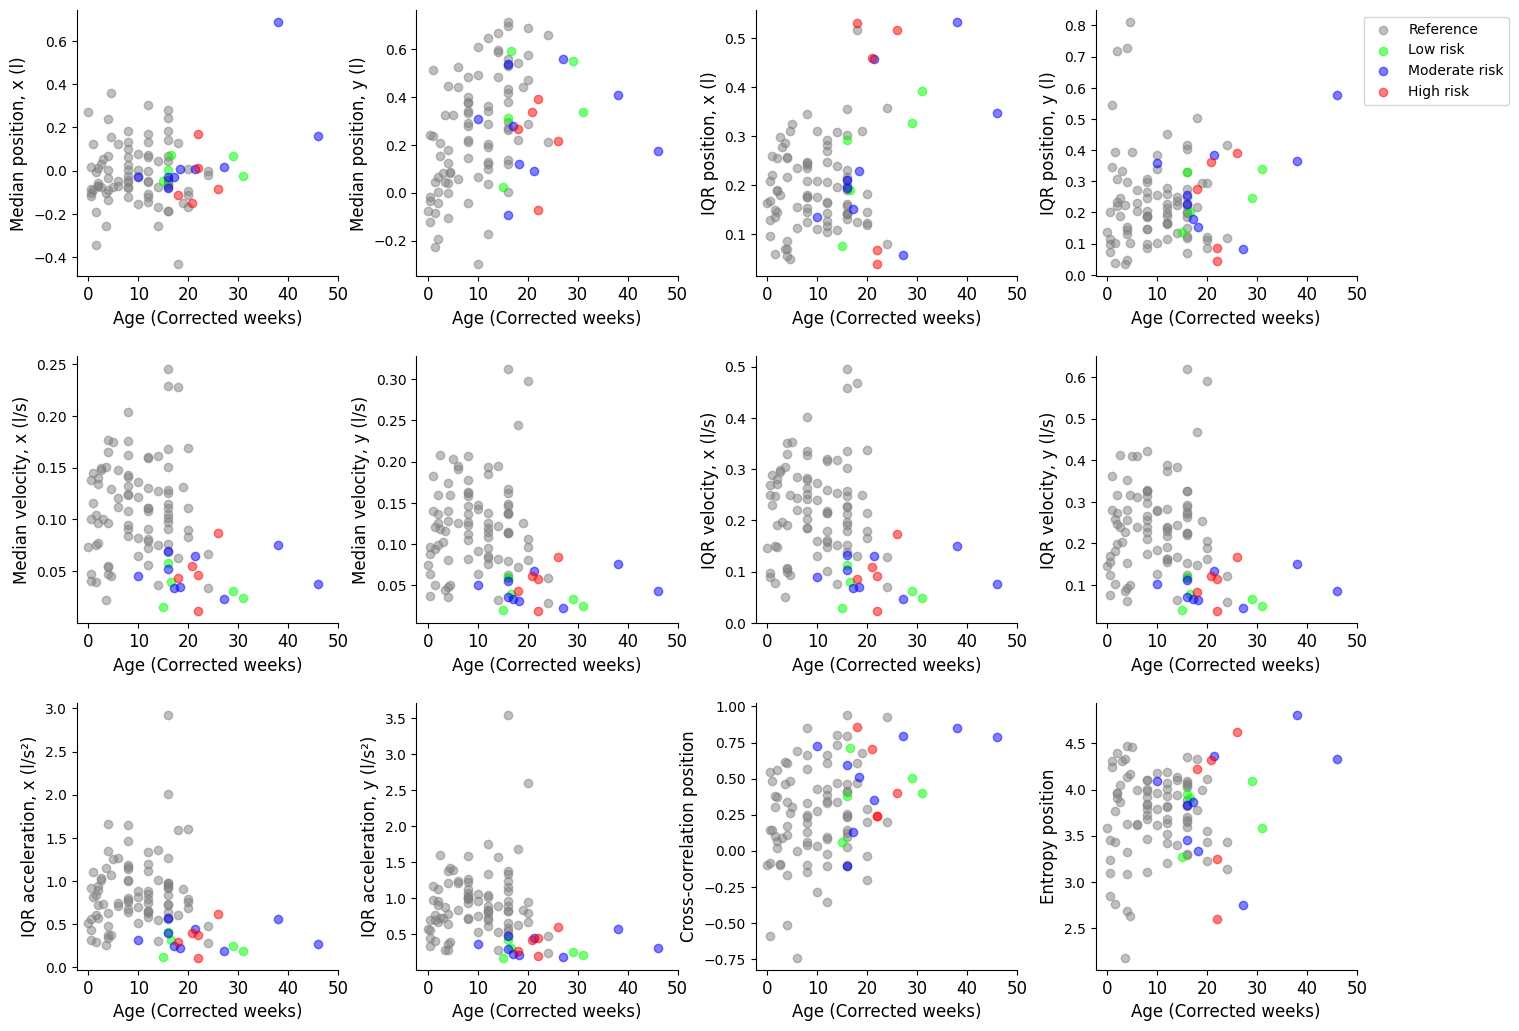

In [11]:
nrow = 3
ncol = 4
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(ncol*s, nrow*s))
for i, icol in enumerate(kp.feature_list_wrists):
    ax = axs.flat[i]
#     ax.text(xlabel, ylabel, labelz[i], transform=ax.transAxes,fontsize=fontsize_label, va='top', ha='right')
    sns.regplot(data=features[(features.risk==0)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5},label='Reference')
    sns.regplot(data=features[(features.risk==1)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5},label='Low risk')
    sns.regplot(data=features[(features.risk==2)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5},label='Moderate risk')
    sns.regplot(data=features[(features.risk==3)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5},label='High risk')
    if i==3:
        ax.legend(bbox_to_anchor=(1,1))    
    ax.set_ylabel(features[features.feature==icol].feature_label.unique()[0],fontsize=fontsize)
    ax.set_xlabel('Age (Corrected weeks)',fontsize=fontsize)
    ax.set_xticks(np.arange(0,60,step=10))
    ax.set_xticklabels(np.arange(0,60,step=10), fontsize=fontsize)
fig.subplots_adjust(left=.1, bottom=.1, right=.9, top=.9, wspace=.3, hspace=.3) 
sns.despine()

## Figure 3

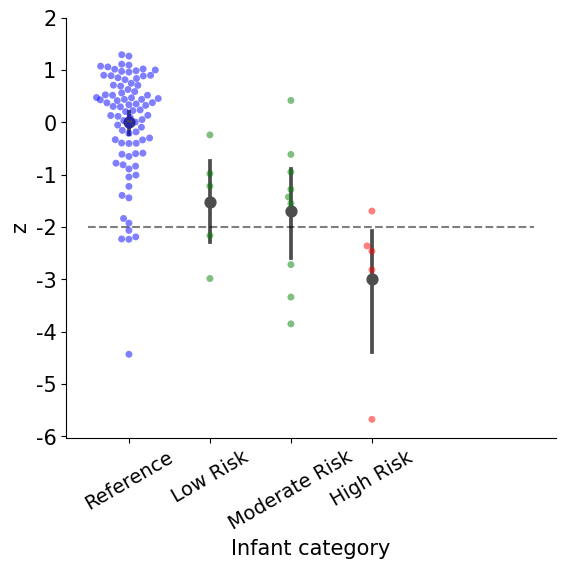

In [35]:
fig,ax=plt.subplots(nrows=1,ncols=1, figsize=(7,7))

sns.swarmplot(ax=ax,x="risk", y="z", data=surprise, alpha=.5, dodge=False,zorder=100, palette=['b','g','g','r'])
sns.pointplot(ax=ax,x="risk", y="z", data=surprise, join=False, color=[.3,.3,.3],zorder=-1, estimator=np.mean)

ax.plot([-0.5,5], [-2]*2, alpha=.5,color=[0,0,0], ls='--')
ax.set_ylabel('z', fontsize=fontsize)
ax.set_xticks(np.arange(0,4))
ax.set_xticklabels(['Reference', 'Low Risk', 'Moderate Risk', 'High Risk'],fontsize=fontsize-1,rotation=30)
ax.set_yticks(np.arange(-6,3))
ax.set_yticklabels(np.arange(-6,3),fontsize=fontsize)

ax.set_xlabel('Infant category',fontsize=fontsize)
sns.despine()

fig.subplots_adjust(left=.2, bottom=.3, right=.9, top=.9, wspace=.2, hspace=.2)

mean_z = surprise.groupby('risk').mean(numeric_only=True)['z'].reset_index()
sd_z = surprise.groupby('risk').std(numeric_only=True)['z'].reset_index()
#print('mean z')
#print(np.around(mean_z.z,decimals=2))
#print('sd z')
#print(np.around(sd_z.z,decimals=2))

## Figure 4

In [36]:
# SVD
A = feature_table.values
U, s, VT = svd(A)
m = A.shape[0]
n = A.shape[1]
sing_val = np.zeros(A.shape, int)
np.fill_diagonal(sing_val, s)
# % variance explained
s2 = s**2
var_exp = s2/np.sum(s2)
var_exp = np.around(var_exp,decimals=2)


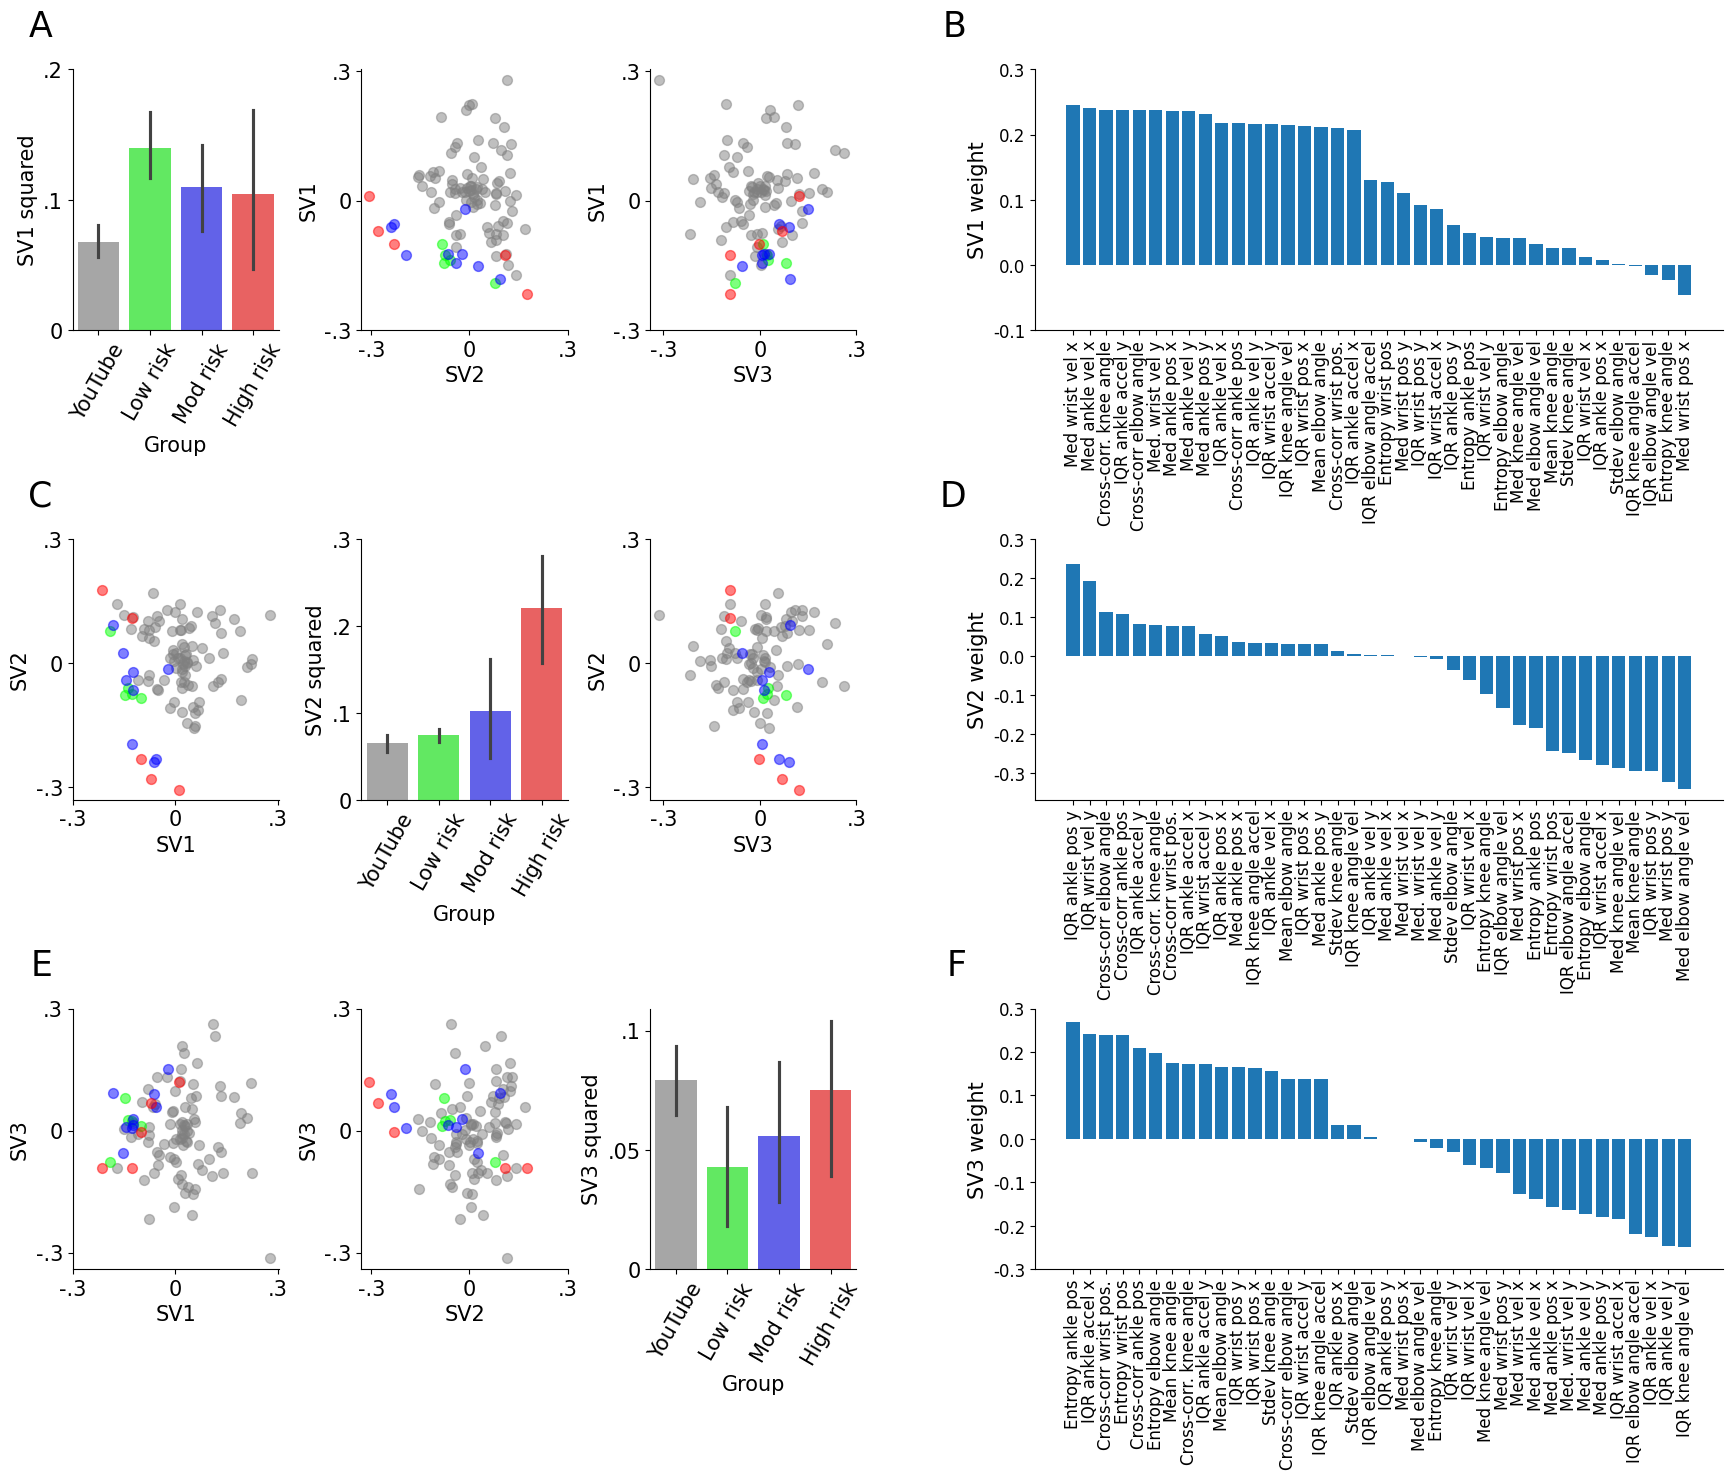

In [37]:
# SVD analysis

rotation=90
fontsize_label = 12
fontsize = 15
size=50
fontsize_panel = 25

p = pd.DataFrame.from_dict({'vt1':VT[0],'vt2':VT[1],'vt3':VT[2],'feature':feature_table.columns.levels[1]})
sv = pd.DataFrame.from_dict({'risk':np.array(feature_table.reset_index().risk), 'sv1': U[:,0], 'sv2': U[:,1],'sv3': U[:,2]})
sv_centered = np.sqrt((sv[['sv1','sv2','sv3']]-sv[['sv1','sv2','sv3']].mean())**2)
sv_centered['risk'] = sv['risk']

fig = plt.figure(figsize=(22,20))

ax = fig.add_subplot(3,6,1)
ax.text(-.1, 1.1, 'A', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
sns.barplot(data = sv_centered, x='risk', y='sv1',ax=ax,alpha=.7, palette=[[.5,.5,.5],[0,1,0],[0,0,1],[1,0,0]])
ax.set_xlabel('Group',fontsize=fontsize)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['YouTube','Low risk','Mod risk','High risk'], rotation=60,fontsize=fontsize)
ax.set_ylabel('SV1 squared',fontsize=fontsize)
ax.set_yticks([0,.1,.2])
ax.set_yticklabels(['0','.1','.2'],fontsize=fontsize)

ax = fig.add_subplot(3,6,2)
sns.regplot(data=sv[sv.risk==0], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV2',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV1',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,3)
sns.regplot(data=sv[sv.risk==0], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV3',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV1',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,2,2)
ax.text(-.1, 1.1, 'B', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
p1 = p.sort_values(by='vt1',ascending=False)
ax.bar(np.arange(len(VT)),p1.vt1)
ax.set_xticks(np.arange(len(VT)))
ax.set_xticklabels(labels = p1.feature,rotation=rotation,fontsize = fontsize_label)
ax.set_yticks(np.arange(-.1,.4,.1))
ax.set_yticklabels(labels = np.around(np.arange(-.1,.4,.1),decimals=1),fontsize = fontsize_label)
ax.set_ylabel('SV1 weight',fontsize=fontsize)

ax = fig.add_subplot(3,6,7)
ax.text(-.1, 1.1, 'C', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
sns.regplot(data=sv[sv.risk==0], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV1',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV2',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,8) 
sns.barplot(data = sv_centered, x='risk', y='sv2',ax=ax, alpha=.7, palette=[[.5,.5,.5],[0,1,0],[0,0,1],[1,0,0]])
ax.set_xlabel('Group',fontsize=fontsize)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['YouTube','Low risk','Mod risk','High risk'], rotation=60,fontsize=fontsize)
ax.set_ylabel('SV2 squared',fontsize=fontsize)
ax.set_yticks([0,.1,.2,.3])
ax.set_yticklabels(['0','.1','.2','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,9)
sns.regplot(data=sv[sv.risk==0], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV3',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV2',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,2,4)
ax.text(-.1, 1.1, 'D', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
p1 = p.sort_values(by='vt2',ascending=False)
ax.bar(np.arange(len(VT)),p1.vt2)
ax.set_xticks(np.arange(len(VT)))
ax.set_xticklabels(labels = p1.feature,rotation=rotation,fontsize = fontsize_label)
ax.set_yticks(np.arange(-.3,.4,.1))
ax.set_yticklabels(labels = np.around(np.arange(-.3,.4,.1),decimals=1),fontsize = fontsize_label)
ax.set_ylabel('SV2 weight',fontsize=fontsize)

ax = fig.add_subplot(3,6,13)
ax.text(-.1, 1.1, 'E', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
sns.regplot(data=sv[sv.risk==0], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV1',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV3',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,14) 
sns.regplot(data=sv[sv.risk==0], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV2',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV3',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,15) 
sns.barplot(data = sv_centered, x='risk', y='sv3',ax=ax, alpha=.7, palette=[[.5,.5,.5],[0,1,0],[0,0,1],[1,0,0]])
ax.set_xlabel('Group',fontsize=fontsize)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['YouTube','Low risk','Mod risk','High risk'], rotation=60,fontsize=fontsize)
ax.set_ylabel('SV3 squared',fontsize=fontsize)
ax.set_yticks([0,.05,.1])
ax.set_yticklabels(['0','.05','.1'],fontsize=fontsize)

ax = fig.add_subplot(3,2,6)
ax.text(-.1, 1.1, 'F', transform=ax.transAxes,fontsize=fontsize_panel, va='bottom', ha='right')
p1 = p.sort_values(by='vt3',ascending=False)
ax.bar(np.arange(len(VT)),p1.vt3)
ax.set_xticks(np.arange(len(VT)))
ax.set_xticklabels(labels = p1.feature,rotation=rotation,fontsize = fontsize_label)
ax.set_yticks(np.arange(-.3,.4,.1))
ax.set_yticklabels(labels = np.around(np.arange(-.3,.4,.1),decimals=1),fontsize = fontsize_label)
ax.set_ylabel('SV3 weight',fontsize=fontsize)

sns.despine()
fig.subplots_adjust(left=.05, bottom=.2, right=.8, top=.8, wspace=.4, hspace=.8)